# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [165]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/migue/.virtualenvs/metnum-tp2/bin/python (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/migue/Desktop/metnum-tp2-2c2020
-- Configuring done
-- G

In [66]:
import dill
knn_df_file = open("data/knn_df", "rb")
try:
    data = knn_df_file.read()
    knn_df = dill.loads(data)
finally:
    knn_df_file.close()
    
pca_df_file = open("data/pca_df", "rb")
try:
    data = pca_df_file.read()
    pca_df = dill.loads(data)
finally:
    pca_df_file.close()

In [166]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum
from commons import *


/home/migue/Desktop/metnum-tp2-2c2020/notebooks
Python 3.8.5


## Explorando los datos

In [168]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Es un csv, con columnas por cada pixel

### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [169]:
#df_train = df_train[:5000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [170]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((42000, 784), (42000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 3


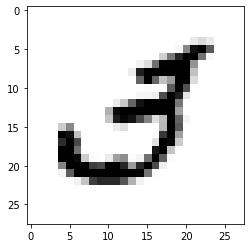

In [171]:
import matplotlib.pyplot as plt

num = 417

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [172]:
df_train["label"].value_counts(normalize=True)

1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [173]:
import random
from functools import reduce

limit = X.shape[0]
order = list(range(0,limit))
random.shuffle(order)

X_shuffled, y_shuffled = [], [] 

for i in order:
    X_shuffled += [X[i]]
    y_shuffled += [y[i]]

K_folds = 5
folds_size = int(limit/K_folds)

X_folds, y_folds = [], []

for i in range(0,K_folds):
    l, h = i * folds_size , (i+1) * folds_size
    X_folds += [X_shuffled[l:h]]
    y_folds += [y_shuffled[l:h]]
    
def getKFold(X_folds,y_folds, K):
    X_train_folds = X_folds[0:K] + X_folds[K+1:len(X_folds)]
    y_train_folds = y_folds[0:K] + y_folds[K+1:len(y_folds)]
    train = (reduce(lambda a,b : a+b,X_train_folds), reduce(lambda a,b : a+b,y_train_folds))
    val = (X_folds[K], y_folds[K])
    return (train,val)

test_train, test_val = getKFold(X_folds,y_folds,4)

X_train, y_train = test_train
X_val , y_val = test_val


assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


In [188]:
# Ejecutar nuestros numeros 

import pandas as pd
from PIL import Image

X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X_train = X
y_train = y
X_val = []
y_val = list(range(10)) * 3 # 0-9 x3
numbers = range(10)

for k in range(3):
    for n in numbers:
        im = Image.open('numbers/' + str(n) + '_' + str(k) + '.png')
        if im.mode == 'P':
            im = im.convert('RGB')
        pix = im.load()
        l = []

        for i in range(28):
            for j in range(28):
                l.append(pix[j,i][0])
        X_val.append(l)
    
print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 42000 instancias de entrenamiento y 30 de validación


In [189]:
%%time
from sklearn.metrics import accuracy_score

clf = metnum.KNNClassifier(5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("Accuracy: {}".format(acc))

Accuracy: 0.5333333333333333
CPU times: user 3.66 s, sys: 327 ms, total: 3.98 s
Wall time: 4 s


In [175]:
%%time
pca = metnum.PCA(28)
pca.fit(X_train)

Y_train = pca.transform(X_train)
Y_test = pca.transform(X_val)

CPU times: user 6.39 s, sys: 588 ms, total: 6.98 s
Wall time: 6.97 s


In [176]:
clf = metnum.KNNClassifier(5)
clf.fit(Y_train, y_train)

In [177]:
%%time
from sklearn.metrics import accuracy_score

y_pred = clf.predict(Y_test)
acc = accuracy_score(y_val, y_pred)

print("Accuracy: {}".format(acc))

Accuracy: 0.9701190476190477
CPU times: user 1min 16s, sys: 365 ms, total: 1min 16s
Wall time: 1min 16s


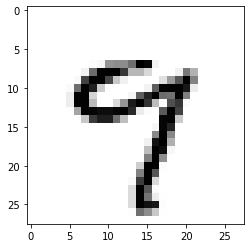

In [179]:
# Graficar numeros incorrectos 

import matplotlib.pyplot as plt

for i in range(len(y_val)):
    if y_val[i] != y_pred[i]:
        img = np.array(X_val[i]).reshape(28, 28)
        plt.imshow(img, cmap="Greys")

In [182]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_val,y_pred)

0.9667838950666002

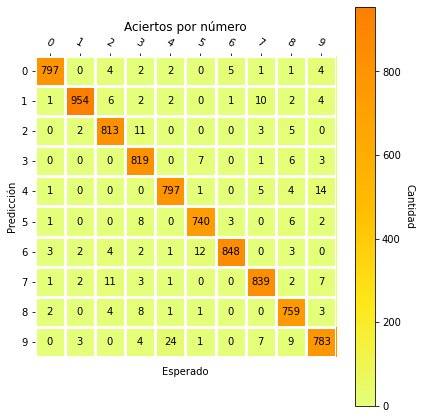

In [183]:
drawConfusionMatrix(y_pred,y_val)

In [184]:
confusion = getConfusionMatrix(y_pred,y_val)
confusions = calculateConfusions(confusion)
precisions = calculatePrecisions(confusions)
recalls = calculateRecalls(confusions)

In [185]:
from datetime import datetime, timedelta
from tqdm import tqdm, trange
from joblib import Parallel, delayed
import multiprocessing

In [186]:
ks = list(range(1, 31))

In [187]:
runs = 1

def calculateDf(X_folds,y_folds,k):
    knn_df = pd.DataFrame(columns = ["k-fold", "k", "accuracy", "precision", "recall", "cohens-kappa", "f1-score", "times", "run"])
    train, val = getKFold(X_folds,y_folds,k)
    for i in tqdm(ks):
        times = timedelta(microseconds=0)
        accs = 0
        for j in range(runs):
            start = datetime.now()
            
            accuracy, precision, recall, cohen, f1 = knn_accuracy(i, train, val)
            
            time = (datetime.now() - start)
            dicc = {"k-fold": k, "k": i, "accuracy": accuracy, "precision": precision, "recall": recall, "cohens-kappa": cohen, "f1-score": f1, "times": time.microseconds, "run": j}
            knn_df = knn_df.append(dicc, ignore_index=True)
    return knn_df
    

num_jobs = max(1, multiprocessing.cpu_count() - 1)
results = Parallel(n_jobs=num_jobs)(delayed(calculateDf)(X_folds,y_folds,k) for k in range(K_folds))
knn_df = pd.DataFrame(columns = ["k-fold", "k", "accuracy", "precision", "recall", "cohens-kappa", "f1-score", "times", "run"])
for df in results:
    knn_df = knn_df.append(df, ignore_index=True)
    
knn_df_file = open("data/knn_df", "wb")
try:
    data = dill.dumps(knn_df)
    knn_df_file.write(data)
finally:
    knn_df_file.close()


KeyboardInterrupt: 

In [74]:
alphas = list(range(1, 31))

In [75]:
k = 5
runs = 1

def calculateDf_pca(X_folds,y_folds,f):
    pca_df = pd.DataFrame(columns = ["k-fold", "alpha", "accuracy", "precision", "recall", "cohens-kappa", "f1-score", "times", "run"])
    train, val = getKFold(X_folds, y_folds, f)
    for i in tqdm(alphas):
        times = timedelta(microseconds=0)
        accs = 0
        for j in range(runs):
            start = datetime.now()
            
            accuracy, precision, recall, cohen, f1 = pca_knn_accuracy(i, k, train, val)
            
            time = (datetime.now() - start)
            dicc = {"k-fold": f, "alpha": i, "accuracy": accuracy, "precision": precision, "recall": recall, "cohens-kappa": cohen, "f1-score": f1, "times": time.microseconds, "run": j}
            pca_df = pca_df.append(dicc, ignore_index=True)
    return pca_df

num_jobs = max(1, multiprocessing.cpu_count() - 1)
results = Parallel(n_jobs=num_jobs)(delayed(calculateDf_pca)(X_folds,y_folds,k) for k in range(K_folds))
pca_df = pd.DataFrame(columns = ["k-fold", "alpha", "accuracy", "precision", "recall", "cohens-kappa", "f1-score", "times", "run"])
for df in results:
    pca_df = pca_df.append(df, ignore_index=True)

pca_df_file = open("data/pca_df", "wb")
try:
    data = dill.dumps(pca_df)
    pca_df_file.write(data)
finally:
    pca_df_file.close()

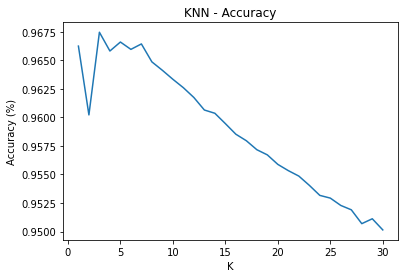

In [76]:
# Plot KNN - Accuracy x K
import matplotlib.pyplot as plt
grouped_knn_df = knn_df.groupby("k").mean()

plt.plot(ks, grouped_knn_df["accuracy"])
plt.title('KNN - Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('K')
plt.show()

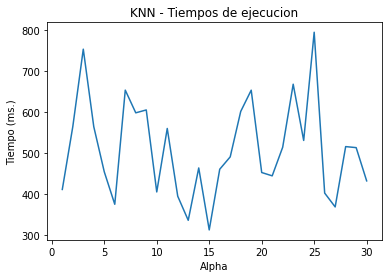

In [77]:
# Plot KNN - Precision + Recall x Kc
plt.plot(ks, grouped_knn_df["times"]/1000)
plt.title('KNN - Tiempos de ejecucion')
plt.ylabel('Tiempo (ms.)')
plt.xlabel('Alpha')
plt.show()

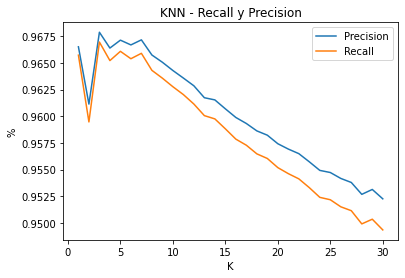

In [78]:
# Plot KNN - Precision + Recall x Kc
plt.plot(ks, grouped_knn_df["precision"], label="Precision")
plt.plot(ks, grouped_knn_df["recall"], label="Recall")
plt.title('KNN - Recall y Precision')
plt.legend()
plt.ylabel('%')
plt.xlabel('K')
plt.show()

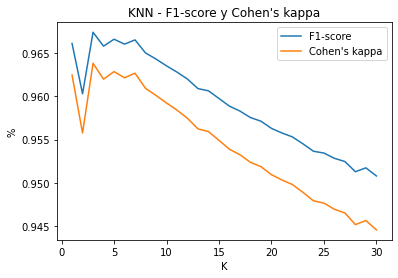

In [79]:
# Plot KNN - F1 score + Cohen's Kappa x K
plt.plot(ks, grouped_knn_df["f1-score"], label="F1-score")
plt.plot(ks, grouped_knn_df["cohens-kappa"], label="Cohen's kappa")
plt.title('KNN - F1-score y Cohen\'s kappa')
plt.legend()
plt.ylabel('%')
plt.xlabel('K')
plt.show()

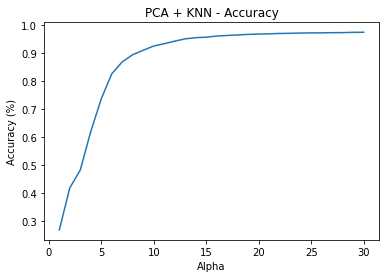

In [80]:
# Plot PCA - Accuracy x Alpha
grouped_pca_df = pca_df.groupby("alpha").mean()

plt.plot(alphas, grouped_pca_df["accuracy"])
plt.title('PCA + KNN - Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Alpha')
plt.show()

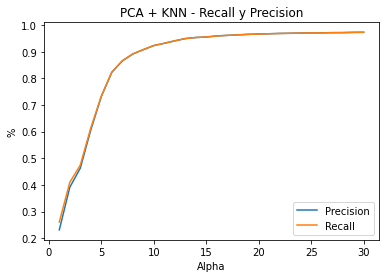

In [81]:
# Plot PCA - Precision + Recall x Alpha
plt.plot(alphas, grouped_pca_df["precision"], label="Precision")
plt.plot(alphas, grouped_pca_df["recall"], label="Recall")
plt.title('PCA + KNN - Recall y Precision')
plt.legend()
plt.ylabel('%')
plt.xlabel('Alpha')
plt.show()

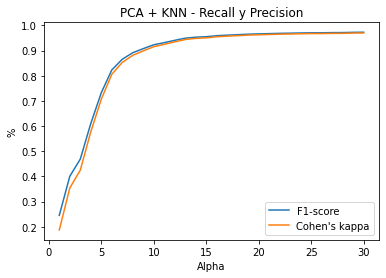

In [82]:
# Plot PCA - F1 score + Cohen's Kappa x Alpha
plt.plot(alphas, grouped_pca_df["f1-score"], label="F1-score")
plt.plot(alphas, grouped_pca_df["cohens-kappa"], label="Cohen's kappa")
plt.title('PCA + KNN - Recall y Precision')
plt.legend()
plt.ylabel('%')
plt.xlabel('Alpha')
plt.show()

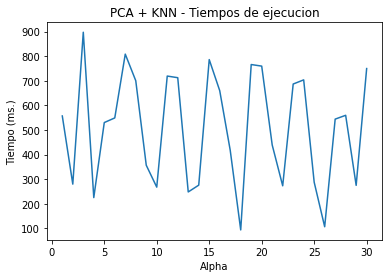

In [83]:
# Plot KNN - Precision + Recall x Kc
plt.plot(alphas, grouped_pca_df["times"]/1000)
plt.title('PCA + KNN - Tiempos de ejecucion')
plt.ylabel('Tiempo (ms.)')
plt.xlabel('Alpha')
plt.show()